# Research Challenge

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Margaret Atwood:</strong> Every aspect of human technology has a dark side, including the bow and arrow.
</div>

## 🏅 Build your own model

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-challenge-25). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed.

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [ ]:
import numpy as np

# Insert your values
Name = "Calysta Aurelia Tesiman" # Replace with your name
CID = 2054243 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: 0" + str(CID) + "]")

This is the work of Calysta Aurelia Tesiman [CID: 02054243]


### Plan for executing regression model
#### Data Preprocessing:
- Visual inspection of data distribution, deciding if we need to deal with oversampling or undersampling (plotly)
- Data cleaning (Pandas)
- Data Featurisation (matminer)
- Scaling of data (sklearn)
#### Model Training and Selection
- Classify (using is_metal dataset)
- Regression (gap_expt dataset)
- Train dataset
#### Model Testing and Optimisation
- Test models and see predictions





## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

--------------------------------------------------------------------------------

Task: Classification to identify if a material is a metal or not, and regression to predict the bandgap of non-metal materials

## Data preparation

Check the data distribution and apply appropriate pre-processing steps as required.

In [ ]:
## Installations and Imports
!pip install pymatgen --quiet
!pip install matminer --quiet
!pip install plotly --quiet
!pip install automatminer --quiet
!pip install elementembeddings --quiet
!pip install smact --quiet
!pip install shap --quiet
!pip install catboost --quiet

import catboost
import pandas as pd
import numpy as np
import plotly.express as px
import sklearn.decomposition as pca
import plotly.graph_objects as go
import smact
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from elementembeddings.composition import composition_featuriser
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,roc_auc_score, ConfusionMatrixDisplay, mean_absolute_error, make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.svm import SVR
# General Matminer imports
from matminer.featurizers.composition import ElementProperty, AtomicOrbitals
from matminer.datasets import get_all_dataset_info, load_dataset

# For working with structures and compositions
from pymatgen.core.structure import Structure
from pymatgen.core.composition import Composition



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━

In [ ]:
## Classifier (metal or not metal)


is_metal = load_dataset("matbench_expt_is_metal")
is_metal['raw composition'] = is_metal.composition.apply(lambda x: Composition(x))

#turn all true and false to 1 and 0
is_metal['is_metal'] = is_metal['is_metal'].astype(int)

element_featuriser = ElementProperty.from_preset(preset_name="magpie")
is_metal = element_featuriser.featurize_dataframe(is_metal, col_id="raw composition" )

is_metal_features = is_metal.columns[3:]
scaler = MinMaxScaler()
is_metal[is_metal_features] = scaler.fit_transform(is_metal[is_metal_features])
# is_metal = is_metal.append(feats)

is_metal

Fetching matbench_expt_is_metal.json.gz from https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz to /usr/local/lib/python3.11/dist-packages/matminer/datasets/matbench_expt_is_metal.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz in MB: 0.034816MB [00:00, 44.85MB/s]                 
/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/4921 [00:00<?, ?it/s]

,composition,is_metal,raw composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Ag(AuS)2,1,"(Ag, Au, S)",0.182927,0.850575,0.688889,0.525226,0.601564,0.164835,0.688172,...,0.000000,0.000000,0.000000,0.000000,0.299559,0.981567,0.682819,0.701357,0.655507,0.299559
1,Ag(W3Br7)2,1,"(Ag, W, Br)",0.414634,0.793103,0.422222,0.516975,0.371344,0.373626,0.537634,...,0.000000,0.000000,0.000000,0.000000,0.273128,1.000000,0.726872,0.501401,0.643871,0.273128
2,Ag0.5Ge1Pb1.75S4,0,"(Ag, Ge, Pb, S)",0.182927,0.885057,0.722222,0.391373,0.560407,0.164835,0.688172,...,0.000000,0.000000,0.000000,0.000000,0.299559,0.981567,0.682819,0.594945,0.675512,0.299559
3,Ag0.5Ge1Pb1.75Se4,0,"(Ag, Ge, Pb, Se)",0.378049,0.885057,0.544444,0.510869,0.413517,0.362637,0.688172,...,0.000000,0.000000,0.000000,0.000000,0.052863,0.981567,0.929515,0.455141,0.919568,0.052863
4,Ag2BBr,1,"(Ag, B, Br)",0.048780,0.482759,0.455556,0.357972,0.338719,0.505495,0.688172,...,0.000000,0.000000,0.000000,0.000000,0.273128,0.981567,0.709251,0.733032,0.484581,0.982379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4916,ZrTaN3,0,"(Zr, Ta, N)",0.073171,0.781609,0.722222,0.277353,0.565342,0.065934,0.462366,...,0.000000,0.000000,0.000000,0.000000,0.845815,1.000000,0.154185,0.873303,0.098678,0.845815
4917,ZrTe,1,"(Zr, Te)",0.475610,0.540230,0.122222,0.508380,0.142123,0.428571,0.462366,...,0.000000,0.000000,0.000000,0.000000,0.660793,0.838710,0.185022,0.746606,0.185022,0.660793
4918,ZrTi2O,1,"(Zr, Ti, O)",0.085366,0.402299,0.344444,0.231629,0.201697,0.230769,0.451613,...,0.000011,0.000006,0.000011,0.000011,0.044053,0.838710,0.801762,0.635747,0.601322,0.845815
4919,ZrTiF6,1,"(Zr, Ti, F)",0.097561,0.402299,0.333333,0.129351,0.195740,0.087912,0.451613,...,0.000011,0.000001,0.000005,0.000000,0.057269,0.838710,0.788546,0.234163,0.591410,0.057269


In [ ]:
# Compute element embeddings using mean pooling


mean_df = composition_featuriser(is_metal["composition"], embedding="magpie", stats=["mean"])
max_df = composition_featuriser(is_metal["composition"], embedding="magpie", stats=["maxpool"])

mean_df['is_metal'] = is_metal['is_metal']
max_df['is_metal'] = is_metal['is_metal']

# Define feature matrices and target variable
cols_to_drop = ['is_metal', 'formula']

X_mean = mean_df.drop(columns=cols_to_drop, errors='ignore').values
X_max = max_df.drop(columns=cols_to_drop, errors='ignore').values

y = is_metal['is_metal'].values  # Target variable

X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)
X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max, y, test_size=0.2, random_state=42)

xgb_mean = XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=1000)
xgb_mean.fit(X_mean_train, y_mean_train)

xgb_max = XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=1000)
xgb_max.fit(X_max_train, y_max_train)

y_predict_mean = xgb_mean.predict(X_mean_test)
y_predict_max = xgb_max.predict(X_max_test)

print(f"Accuracy of Classifier (mean pooling): {roc_auc_score(y_mean_test, y_predict_mean)}")
print(f"Accuracy of Classifier (max pooling): {roc_auc_score(y_max_test, y_predict_max)}")

print(f'ROC_AUC of XGBClassifier: {roc_auc_score(y_mean_test, y_predict_mean)}')

cv_scores_mean_xgb = cross_val_score(xgb_mean, X_mean, y, cv=5, scoring='roc_auc')


Featurising compositions...


100%|██████████| 4921/4921 [00:11<00:00, 415.27it/s]


Computing feature vectors...


100%|██████████| 4921/4921 [00:00<00:00, 162786.35it/s]


Featurising compositions...


100%|██████████| 4921/4921 [00:11<00:00, 422.38it/s]


Computing feature vectors...


100%|██████████| 4921/4921 [00:00<00:00, 119328.03it/s]


Accuracy of Classifier (mean pooling): 0.900165609409588
Accuracy of Classifier (max pooling): 0.8831730928073479
ROC_AUC of XGBClassifier: 0.900165609409588


In [ ]:
## classifying using catboost and using meanpooling
cat_classify = CatBoostClassifier(verbose=False, learning_rate=0.04)

cat_classify.fit(X_mean_train, y_mean_train)
y_predicted = cat_classify.predict(X_mean_test)

cat_cv_scores = cross_val_score(cat_classify, X_mean_train, y_mean_train, cv=5, scoring='roc_auc')
cat_accuracy = np.mean(cat_cv_scores)

print(cat_accuracy)
print(balanced_accuracy_score(y_mean_test, y_predicted))
print(f'ROC_AUC of CatBoostClassifier: {roc_auc_score(y_mean_test, y_predicted)}') # beats gptchem :) (before gridsearch)

0.9642248055890856
0.9086401856807744
ROC_AUC of CatBoostClassifier: 0.9086401856807744


In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('XGBClassifier', 'CatBoostClassifier'))

fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=cv_scores_mean_xgb,
    mode='lines+markers',
    name='Mean Pooling (XGB)',
    marker=dict(size=10)
), row=1, col=1)



fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=cat_cv_scores,
    mode='lines+markers',
    name='Mean Pooling (CatBoost)',
    marker=dict(size=10)
), row=1, col=2)

fig.update_layout(
    title='Cross-Validation ROC AUC Scores: XGBClassifier vs CatBoostClassifier',
    xaxis_title='Fold',
    yaxis_title='ROC AUC Score',
    legend_title='Pooling Method',
    template='plotly_white',
    hovermode='x unified'
)

fig.update_xaxes(title_text='Fold', row=1, col=1)
fig.update_xaxes(title_text='Fold', row=1, col=2)
fig.update_yaxes(title_text='ROC AUC Score', row=1, col=1)
fig.update_yaxes(title_text='ROC AUC Score', row=1, col=2)


fig.show()

In [ ]:
#GridSearch

catboost_grid = {'depth'         : [6,8, 10],
                 'learning_rate' : [0.04, 0.05, 0.07, 1]
                 }

catboost_grid_search = GridSearchCV(CatBoostClassifier(), catboost_grid, cv=5, scoring='accuracy', n_jobs=-1)
catboost_grid_search.fit(X_mean_train, y_mean_train)

best_catboost_params = catboost_grid_search.best_params_
best_catboost_model = catboost_grid_search.best_estimator_

0:	learn: 0.6606053	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6333443	total: 20.2ms	remaining: 10.1s
2:	learn: 0.6067528	total: 29.4ms	remaining: 9.78s
3:	learn: 0.5843295	total: 38.8ms	remaining: 9.67s
4:	learn: 0.5605857	total: 54.6ms	remaining: 10.9s
5:	learn: 0.5391142	total: 61.1ms	remaining: 10.1s
6:	learn: 0.5212525	total: 67.7ms	remaining: 9.6s
7:	learn: 0.5035234	total: 74.1ms	remaining: 9.19s
8:	learn: 0.4881533	total: 80.6ms	remaining: 8.88s
9:	learn: 0.4720544	total: 85.6ms	remaining: 8.47s
10:	learn: 0.4572813	total: 90.7ms	remaining: 8.15s
11:	learn: 0.4450582	total: 95.7ms	remaining: 7.88s
12:	learn: 0.4332709	total: 101ms	remaining: 7.65s
13:	learn: 0.4229138	total: 106ms	remaining: 7.45s
14:	learn: 0.4133516	total: 111ms	remaining: 7.29s
15:	learn: 0.4051448	total: 116ms	remaining: 7.16s
16:	learn: 0.3981412	total: 121ms	remaining: 7.02s
17:	learn: 0.3902376	total: 126ms	remaining: 6.89s
18:	learn: 0.3841079	total: 131ms	remaining: 6.79s
19:	learn: 0.3777547	total: 13

In [ ]:
print(best_catboost_params)


{'depth': 6, 'learning_rate': 0.04}


In [ ]:
#Retraining model with best hyperparameters
cat_classify = CatBoostClassifier(verbose=False, learning_rate=0.04, depth=6)

cat_classify.fit(X_mean_train, y_mean_train)
y_predicted = cat_classify.predict(X_mean_test)

cat_cv_scores = cross_val_score(cat_classify, X_mean_train, y_mean_train, cv=5, scoring='roc_auc')
cat_accuracy = np.mean(cat_cv_scores)

print(f'Accuracy: {cat_accuracy}')
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_mean_test, y_predicted)}")
print(f'ROC_AUC of CatBoostClassifier: {roc_auc_score(y_mean_test, y_predicted)}')



Accuracy: 0.9642248055890856
Balanced Accuracy Score: 0.9086401856807744
ROC_AUC of CatBoostClassifier: 0.9086401856807744


Confusion matrix, without normalization
[[466  47]
 [ 43 429]]
Normalized confusion matrix
[[0.90838207 0.09161793]
 [0.09110169 0.90889831]]


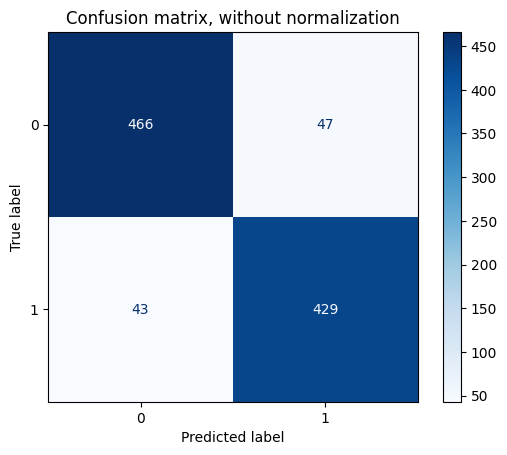

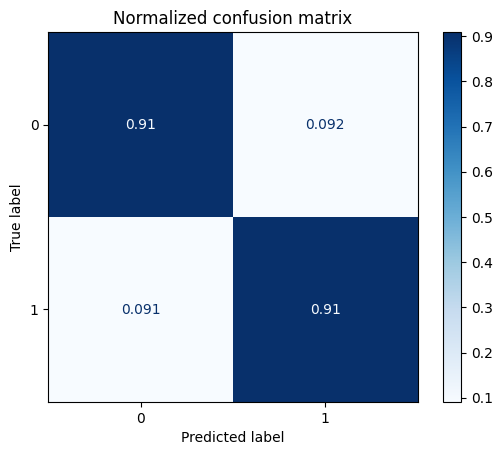

In [ ]:
#Confusion Matrix of classifier
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        cat_classify,
        X_mean_test,
        y_mean_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
df = load_dataset("matbench_expt_gap")

df['raw composition'] = df.composition.apply(lambda x: Composition(x))
element_featuriser = ElementProperty.from_preset(preset_name="magpie")
orbital_featuriser = AtomicOrbitals()

df_featurised = element_featuriser.featurize_dataframe(df, col_id = 'raw composition')
df_featurised = orbital_featuriser.featurize_dataframe(df_featurised, col_id = 'raw composition', ignore_errors=True)

df_featurised= df_featurised.drop(columns=['HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element'])

Fetching matbench_expt_gap.json.gz from https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz to /usr/local/lib/python3.11/dist-packages/matminer/datasets/matbench_expt_gap.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz in MB: 0.038911999999999995MB [00:00, 39.09MB/s]   
/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning:

MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.



ElementProperty:   0%|          | 0/4604 [00:00<?, ?it/s]

AtomicOrbitals:   0%|          | 0/4604 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




CatBoost Cross-Validation Results
  Mean RMSE: 0.619
  Mean MAE: 0.4105151115298744
  Standard Deviation of MAE: 0.03790764741243736
XGB Cross-Validation Results
  Mean RMSE: 0.667
  Mean MAE: 0.45218795858764177
  Standard Deviation of MAE: 0.0411623846748268
SVR Cross-Validation Results
  Mean RMSE: 0.798
  Mean MAE: 0.5316415675218534
  Standard Deviation of MAE: 0.03434782362925547


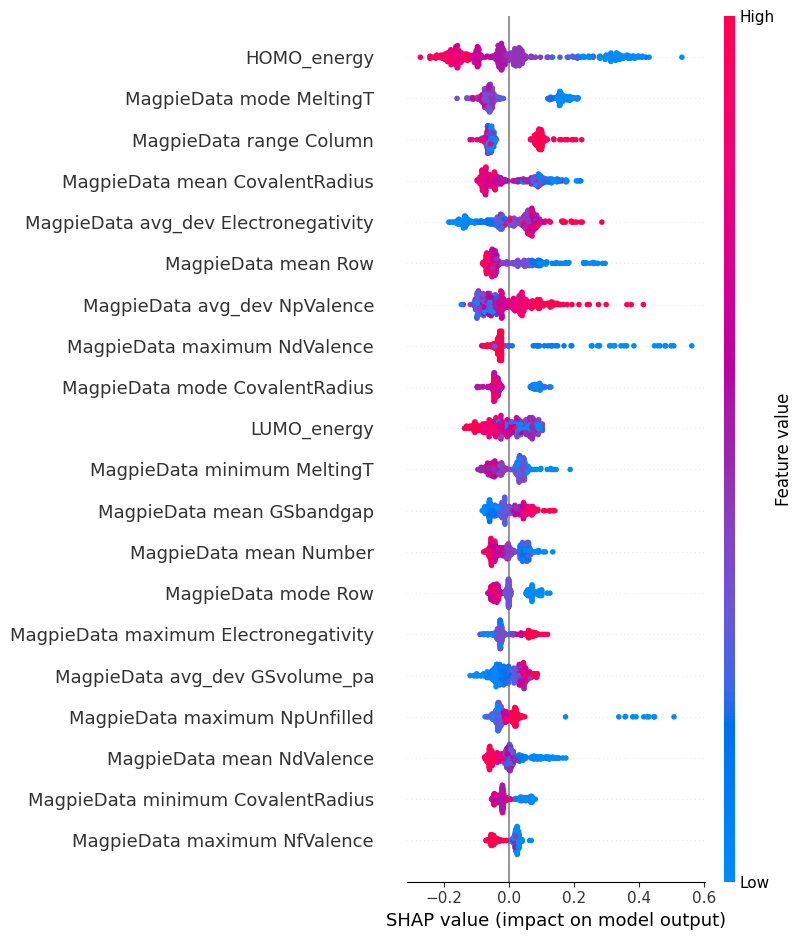

In [ ]:

metals = df_featurised[df_featurised['gap expt'] == 0]
df_featurised= df_featurised[df_featurised['gap expt'] != 0]

# Scaling the data
scaler = MinMaxScaler()
cols_to_drop = ['composition', 'raw composition', 'gap expt']

feature_cols = [feat for feat in list(df_featurised.columns) if feat not in cols_to_drop]

# Apply the scaler to the insulators and semiconductors
df_featurised[feature_cols] = scaler.fit_transform(df_featurised[feature_cols])
scaled_X = df_featurised[feature_cols].values
y = df_featurised['gap expt'].values

# Rough regression on whole database and classify if material is semiconductor or an insulator
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42) ## Challenge: to keep test size to half and improve accuracy of test to atleast 90 percent


# comparing models
cat = CatBoostRegressor(loss_function="RMSE", verbose=False, learning_rate=0.05)
xgb = XGBRegressor(n_estimators=100, max_depth=3, random_state=42, objective='reg:squarederror')
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)
cat.fit(X_train, y_train)
xgb.fit(X_train, y_train)
predicted_bg = cat.predict(X_test)
predicted_bg_xgb = xgb.predict(X_test)
predicted_bg_svr = svr.predict(X_test)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test,
    y=predicted_bg,
    mode='markers',
    marker=dict(color=y_test, colorscale='Greens', showscale=True)))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predicted_bg_xgb,
    mode='markers',
    marker=dict(color=y_test, colorscale='Blues', showscale=True)))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predicted_bg_svr,
    mode='markers',
    marker=dict(color=y_test, colorscale='Oranges', showscale=True)))
fig.add_trace(go.Line(x=y_test, y=y_test))


fig.update_layout(title="Band gap rough prediction using Various Regressors",xaxis_title='Ground Truth Bandgap', yaxis_title="Predicted Bandgap", width=600,height=400)
fig.show()

# print(f'r^2 score of model for rough prediction (training): {cat.score(X_train, y_train)}')
# print(f'r^2 score of model for rough prediction (test): {cat.score(X_test, y_test)}')
cat_cv_scores_rmse = cross_val_score(cat, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_cv_scores_rmse = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
svr_cv_scores_rmse = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

cat_rmse = np.sqrt(-cat_cv_scores_rmse)
xgb_rmse = np.sqrt(-xgb_cv_scores_rmse)
svr_rmse = np.sqrt(-svr_cv_scores_rmse)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

cat_cv_scores_mae = cross_val_score(cat, X_train, y_train, cv=5, scoring=mae_scorer)
xgb_cv_scores_mae = cross_val_score(xgb, X_train, y_train, cv=5, scoring=mae_scorer)
svr_cv_scores_mae = cross_val_score(svr, X_train, y_train, cv=5, scoring=mae_scorer)

mean_mae_cat = -np.mean(cat_cv_scores_mae)
mean_mae_xgb = -np.mean(xgb_cv_scores_mae)
mean_mae_svr = -np.mean(svr_cv_scores_mae)

fig = make_subplots(rows=1, cols=2, subplot_titles=('RMSE Scores', 'MAE Scores'))

# Add RMSE traces
fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=cat_cv_scores_rmse,
    mode='lines+markers',
    name='CatBoost (RMSE)',
    marker=dict(size=10)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=xgb_cv_scores_rmse,
    mode='lines+markers',
    name='XGBoost (RMSE)',
    marker=dict(size=10)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=svr_cv_scores_rmse,
    mode='lines+markers',
    name='SVR (RMSE)',
    marker=dict(size=10)
), row=1, col=1)

# Add MAE traces
fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=cat_cv_scores_mae,
    mode='lines+markers',
    name='CatBoost (MAE)',
    marker=dict(size=10)
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=xgb_cv_scores_mae,
    mode='lines+markers',
    name='XGBoost (MAE)',
    marker=dict(size=10)
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(1, 6)),
    y=svr_cv_scores_mae,
    mode='lines+markers',
    name='SVR (MAE)',
    marker=dict(size=10)
), row=1, col=2)

# Update layout
fig.update_layout(
    title='Cross-Validation Scores: RMSE and MAE',
    xaxis_title='Fold',
    yaxis_title='Score',
    legend_title='Model',
    template='plotly_white',
    hovermode='x unified'
)

# Update subplot axes
fig.update_xaxes(title_text='Fold', row=1, col=1)
fig.update_xaxes(title_text='Fold', row=1, col=2)
fig.update_yaxes(title_text='RMSE', row=1, col=1)
fig.update_yaxes(title_text='MAE', row=1, col=2)


print("CatBoost Cross-Validation Results")
print(f"  Mean RMSE: {cat_rmse.mean():.3f}")
print(f"  Mean MAE: {mean_mae_cat}")
print(f"  Standard Deviation of MAE: {cat_cv_scores_mae.std()}")

print("XGB Cross-Validation Results")
print(f"  Mean RMSE: {xgb_rmse.mean():.3f}")
print(f"  Mean MAE: {mean_mae_xgb}")
print(f"  Standard Deviation of MAE: {xgb_cv_scores_mae.std()}")

print("SVR Cross-Validation Results")
print(f"  Mean RMSE: {svr_rmse.mean():.3f}")
print(f"  Mean MAE: {mean_mae_svr}")
print(f"  Standard Deviation of MAE: {svr_cv_scores_mae.std()}")
fig.show()

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = feature_cols)


In [ ]:
# Hyperparameter tuning of chosen model - CatBoost
catboost_grid = {'depth'         : [6,8, 10],
                 'learning_rate' : [0.04, 0.05, 0.07, 1]
                 }

catboost_grid_search = GridSearchCV(CatBoostRegressor(), catboost_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
catboost_grid_search.fit(X_train, y_train)

best_catboost_params = catboost_grid_search.best_params_
best_catboost_model = catboost_grid_search.best_estimator_

print(best_catboost_params)

0:	learn: 1.4143696	total: 11.5ms	remaining: 11.5s
1:	learn: 1.3618725	total: 22.2ms	remaining: 11.1s
2:	learn: 1.3134725	total: 32.5ms	remaining: 10.8s
3:	learn: 1.2695202	total: 42.9ms	remaining: 10.7s
4:	learn: 1.2271975	total: 53.4ms	remaining: 10.6s
5:	learn: 1.1901450	total: 65.9ms	remaining: 10.9s
6:	learn: 1.1537026	total: 76ms	remaining: 10.8s
7:	learn: 1.1249074	total: 86.4ms	remaining: 10.7s
8:	learn: 1.0933045	total: 96.9ms	remaining: 10.7s
9:	learn: 1.0652583	total: 107ms	remaining: 10.6s
10:	learn: 1.0408285	total: 117ms	remaining: 10.5s
11:	learn: 1.0153073	total: 128ms	remaining: 10.5s
12:	learn: 0.9960684	total: 138ms	remaining: 10.5s
13:	learn: 0.9745055	total: 149ms	remaining: 10.5s
14:	learn: 0.9545235	total: 159ms	remaining: 10.5s
15:	learn: 0.9367706	total: 170ms	remaining: 10.5s
16:	learn: 0.9189777	total: 180ms	remaining: 10.4s
17:	learn: 0.9039901	total: 190ms	remaining: 10.4s
18:	learn: 0.8884590	total: 201ms	remaining: 10.4s
19:	learn: 0.8751190	total: 214ms	

In [ ]:
cat = CatBoostRegressor(loss_function="RMSE", verbose=False, learning_rate=0.07, depth = 6)
cat.fit(X_train, y_train)
predicted_bg = cat.predict(X_test)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test,
    y=predicted_bg,
    mode='markers',
    marker=dict(color=y_test, colorscale='Viridis', showscale=True)))
fig.add_trace(go.Line(x=y_test, y=y_test))
fig.update_layout(title="Band gap prediction using Optimised CatBoost Regressors",xaxis_title='Ground Truth Bandgap', yaxis_title="Predicted Bandgap", width=600,height=400)
fig.show()

cat_cv_scores_rmse = cross_val_score(cat, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cat_cv_scores_mae = cross_val_score(cat, X_train, y_train, cv=5, scoring=mae_scorer)
cat_rmse = np.sqrt(-cat_cv_scores_rmse)
mean_mae_cat = -np.mean(cat_cv_scores_mae)

print("CatBoost Cross-Validation Results after Hyperparameter Tuning")
print(f"  Mean RMSE: {cat_rmse.mean():.3f}")
print(f"  Mean MAE: {mean_mae_cat}")
print(f"  Standard Deviation of MAE: {cat_cv_scores_mae.std()}")

/usr/local/lib/python3.11/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




CatBoost Cross-Validation Results after Hyperparameter Tuning
  Mean RMSE: 0.606
  Mean MAE: 0.39921002025688246
  Standard Deviation of MAE: 0.03450396956880855


In [ ]:
# Feature Distribution
importances = cat.feature_importances_

feature_names = feature_cols


feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


top_n = 20
top_features = feature_importance_df.head(top_n)

fig = px.bar(
    top_features,
    x='Feature',
    y='Importance',
    title=f'Top {top_n} Important Features',
    labels={'Feature': 'Feature', 'Importance': 'Importance Score'},
    color='Importance',
    color_continuous_scale='Viridis'
)

fig.show()

In [ ]:
print(f"R^2 value of optimised regressor = {cat.score(X_test, y_test)}")

0.831219384496777


In [ ]:
# Comparison to MatBench Discovery
stats = {
    "algorithm": ["Darwin", "Ax/SAASBO CrabNet v1.2.7", "MODNet (v0.1.12)", "CrabNet", "MODNet (v0.1.10)",
                  "Ax+CrabNet v1.2.1", "Ax(10/90)+CrabNet v1.2.7", "CrabNet v1.2.1", "AMMExpress v2020",
                  "RF-SCM/Maggie", "gptchem", "Dummy"],
    "mean mae": [0.2865, 0.3310, 0.3327, 0.3463, 0.3470, 0.3566, 0.3632, 0.3757, 0.4161, 0.4461, 0.4544, 1.1435],
    "std mae": [0.0083, 0.0071, 0.0239, 0.0088, 0.0222, 0.0248, 0.0196, 0.0207, 0.0194, 0.0177, 0.0123, 0.0310],
    "mean rmse": [0.7185, 0.8123, 0.7685, 0.8504, 0.7437, 0.8673, 0.8679, 0.8805, 0.9918, 0.8243, 1.0737, 1.4438]
}

df = pd.DataFrame(stats)

catboost_data = {
    "algorithm": ["CatBoost"],
    "mean mae": [0.3992],
    "std mae": [0.0345],
    "mean rmse": [0.606]
}

catboost_df = pd.DataFrame(catboost_data)
df = pd.concat([df, catboost_df], ignore_index=True)

fig = px.scatter(
    df,
    x="mean rmse",
    y="mean mae",
    color="std mae",
    size=[18 if algo == "CatBoost" else 8 for algo in df["algorithm"]],
    title="Comparison plot",
    labels={"mean rmse": "Mean RMSE", "mean mae": "Mean MAE", "std mae": "Std MAE"},
    hover_data=["algorithm", "mean rmse", "mean mae", "std mae"],
    color_continuous_scale="Viridis"
)

fig.show()


## Pipeline

In [ ]:
# Pipeline
Materials = ['SiO2', 'AgBr', 'Ag(AuS)2', 'CH4', 'Al']
out = pd.DataFrame({'materials': Materials, 'is_metal': [None]*len(Materials), 'bandgap': [None]*len(Materials)})

for i, material in enumerate(Materials):
  new_material = composition_featuriser([material], embedding="magpie", stats=["mean"])
  mat_predict = cat_classify.predict(new_material)[0]
  out.loc[i, 'is_metal'] = mat_predict

  if mat_predict == 0:
    new_material_comp = Composition(material)
    new_material_feats = element_featuriser.featurize(new_material_comp)
    new_material_orbs = orbital_featuriser.featurize(new_material_comp)
    new_material_orbs = pd.Series(new_material_orbs, index=orbital_featuriser.feature_labels())
    new_material_orbs = new_material_orbs.drop(index=['HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element'])
    features = np.concatenate([new_material_feats, new_material_orbs.values])
    # Reshape the features to a 2D array
    scaled_features = scaler.transform(features.reshape(1, -1))
    bg_pred = cat.predict(scaled_features)[0]
    out.loc[i, 'bandgap'] = bg_pred
  else:
    out.loc[i, 'bandgap'] = 0


out


100%|██████████| 1/1 [00:00<00:00, 6615.62it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

100%|██████████| 1/1 [00:00<00:00, 2876.75it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

100%|██████████| 1/1 [00:00<00:00, 5229.81it/s]


,materials,is_metal,bandgap
0,SiO2,0,5.569473
1,AgBr,0,2.602919
2,Ag(AuS)2,1,0
3,CH4,1,0
4,Al,1,0


## Large Language Model (LLM) usage declaration

Acknowledge use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-4, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

I used ChatGPT and DeepSeek in helping me generate plots using Plotly. The limitations was that it wouldn't refactor a lot of my code so I had to refactor it myself. I didn't use LLMs to develop my models to ensure ethical use of LLMs

## ☘️ Final word

Good luck building your own model! We hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page.

Remember that submission is on Blackboard and you should upload both the completed Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).